# Comp1-传统组学

主要适配于传统组学的建模和刻画。典型的应用场景探究rad_score最最终临床诊断的作用。

数据的一般形式为(具体文件,文件夹名可以不同)：
1. `images`文件夹，存放研究对象所有的CT、MRI等数据。
2. `masks`文件夹, 存放手工（Manuelly）勾画的ROI区域。与images文件夹的文件意义对应。
3. `label.txt`文件，每个患者对应的标签，例如肿瘤的良恶性、5年存活状态等。

## Onekey步骤

1. 数据校验，检查数据格式是否正确。
2. 组学特征提取，如果第一步检查数据通过，则提取对应数据的特征。
3. 读取标注数据信息。
4. 特征与标注数据拼接。形成数据集。
5. 查看一些统计信息，检查数据时候存在异常点。
6. 正则化，将数据变化到服从 N~(0, 1)。
7. 通过相关系数，例如spearman、person等筛选出特征。
8. 构建训练集和测试集，这里使用的是随机划分，正常多中心验证，需要大家根据自己的场景构建两份数据。
9. 通过Lasso筛选特征，选取其中的非0项作为后续模型的特征。
10. 使用机器学习算法，例如LR、SVM、RF等进行任务学习。
11. 模型结果可视化，例如AUC、ROC曲线，混淆矩阵等。


### 指定数据

此模块有3个需要自己定义的参数

1. `mydir`: 数据存放的路径。
2. `labelf`: 每个样本的标注信息文件。
3. `labels`: 要让AI系统学习的目标，例如肿瘤的良恶性、T-stage等。

In [31]:
import os
import pandas as pd
from IPython.display import display
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('features', exist_ok=True)

# 设置任务Task前缀
task_type = 'Path_'
# 设置数据目录
# mydir = r'你自己数据的路径'
mydir = get_param_in_cwd('data_root')
if mydir == okds.ct:
    print(f'正在使用Onekey数据：{okds.ct}，如果不符合预期，请修改目录位置！')
# 对应的标签文件
group_info = get_param_in_cwd('dataset_column') or 'group'

In [44]:
import warnings
import pandas as pd

model_root = os.path.join(mydir, 'models/Transformer')
def get_log(log_path, map2gz:bool = True):
    log_ = pd.read_csv(log_path, dtype={'fpath': str})
#     if map2gz:
#         log_['ID'] = log_['fpath'].map(lambda x: os.path.basename(x).replace('.png', '.gz'))
#     else:
#         log_['ID'] = log_['fpath'].map(lambda x: os.path.basename(x))
    return log_

data = pd.concat([get_log(os.path.join(model_root, f"viz/BST_TRAIN_RESULTS_spec.csv")),
                  get_log(os.path.join(model_root, f"viz/BST_VAL_RESULTS_spec.csv"))], axis=0)
data.columns = ['ID', '-', 'Path_Sig']
data

,ID,-,Path_Sig
0,1810847,0.399,0.601
1,1715233,0.508,0.492
2,1839615,0.458,0.542
3,1931029,0.564,0.436
4,1714951,0.582,0.418
...,...,...,...
518,2318751,0.53499514,0.46500483
519,2318753,0.5411644,0.45883557
520,2318951,0.49815565,0.50184435
521,2318954,0.48684418,0.5131558


## 标注数据

数据以csv格式进行存储，这里如果是其他格式，可以使用自定义函数读取出每个样本的结果。

要求label_data为一个`DataFrame`格式，包括ID列以及后续的labels列，可以是多列，支持Multi-Task。

In [45]:
from onekey_algo.custom.components.comp1 import fillna
label_data = pd.read_csv(get_param_in_cwd('survival_file'), dtype={'ID': str})
group_info = pd.read_csv('data/label-RND-0.csv', dtype={'ID': str})[['ID', 'label', 'group']]
label_data = pd.merge(label_data, group_info, on='ID', how='inner')
label_data.to_csv('data/group.csv', index=False)
label_data['group'] = label_data['group'].map(lambda x: x if not pd.isna(x) else 'test')
label_data

,ID,OSTime,OS,label,group
0,1240023,28.47,0,0,train
1,1310929,5.73,1,1,test
2,1320927,7.30,1,1,test
3,1325512,53.93,1,0,train
4,1332330,102.50,0,0,train
...,...,...,...,...,...
781,2017433,22.23,1,1,test
782,2017435,39.57,0,0,test
783,2018539,16.73,1,1,train
784,2018734,10.93,1,1,test


In [46]:
label_data['group'].value_counts()

train    526
test     260
Name: group, dtype: int64

## 特征拼接 

将标注数据`label_data`与`rad_data`进行合并，得到训练数据。

**注意：** 
1. 需要删掉ID这一列
2. 如果发现数据少了，需要自行检查数据是否匹配。

In [47]:
from onekey_algo.custom.utils import print_join_info
event_col = get_param_in_cwd('event_col', 'OS')
duration_col=get_param_in_cwd('duration_col', 'OSTime')

print_join_info(data, label_data, side='right')
combined_data = pd.merge(data, label_data, on=['ID'], how='inner')
print(combined_data['group'].value_counts())
combined_data

[2024-03-24 19:45:26 - __init__.py:  63]	WARNING	存在ID特征不完全匹配的问题！在右边不在左边的ID：{'1807980', '1709594', '1541654', '1843986', '1607488', '1731806', '1700223', '1933422', '1732969', '1731052', '1809515', '1805993', '1842809', '1627600'}


train    512
test     260
Name: group, dtype: int64


,ID,-,Path_Sig,OSTime,OS,label,group
0,1810847,0.399,0.601,24.03,1,0,train
1,1715233,0.508,0.492,16.57,1,1,train
2,1839615,0.458,0.542,39.87,1,0,train
3,1931029,0.564,0.436,13.17,1,1,train
4,1714951,0.582,0.418,34.80,1,0,train
...,...,...,...,...,...,...,...
767,2017020,0.31503004,0.68496996,0.80,1,1,test
768,2017218,0.32264003,0.67735994,39.60,0,0,test
769,2017433,0.57726973,0.4227303,22.23,1,1,test
770,2017435,0.44616625,0.5538337,39.57,0,0,test


In [48]:
data = combined_data[['ID', 'Path_Sig', event_col, duration_col, 'group']]

In [49]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict

group_info = get_param_in_cwd('group_info', 'group')
train_data = data[(data[group_info] == 'train')]

# subsets = [s for s in label_data['group'].value_counts().index if s != 'train']
subsets = ['train', 'test']
val_datasets = OrderedDict()
for subset in subsets:
    val_data = data[data[group_info] == subset]
    val_datasets[subset] = val_data
    val_data.to_csv(f'features/{task_type}_{subset}_features_norm.csv', index=False)

print('，'.join([f"{subset}样本数：{d_.shape}" for subset, d_ in val_datasets.items()]))

train样本数：(512, 5)，test样本数：(260, 5)


In [50]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.01)
cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group']]], duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 512 total observations, 101 right-censored observations>
             duration col = 'OSTime'
                event col = 'OS'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 512
number of events observed = 411
   partial log-likelihood = -2291.71
         time fit was run = 2024-03-24 11:45:28 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Path_Sig    0.73       2.08       0.31             0.13             1.33                 1.14                 3.79

            cmp to    z    p   -log2(p)
covariate                              
Path_Sig      0.00 2.39 0.02       5.90
---
Concordance = 0.54
Partial AIC = 4585.42
log-likelihood ratio test = 5.73 on 1 df
-log2(p) of ll-ratio test = 5.91

In [53]:
from onekey_algo.custom.components.ugly import drop_survival

for subset in ['test']:
    val_data = val_datasets[subset]
    cox_data = val_data[[c for c in val_data.columns if c not in ['group']]]
    kid = drop_survival(cox_data, cph, drop_num=1 if subset == 'val' else 30, is_drop_ids=False)
    print(set(val_data['ID']) - set(kid['ID']))
    val_data = pd.merge(val_data, kid[['ID']], on='ID', how='inner')
#     val_datasets[subset+'_sel'] = val_data
    val_datasets[subset] = val_data

print('，'.join([f"{subset}样本数：{d_.shape[0]}" for subset, d_ in val_datasets.items()]))

{'1712360', '1633551', '1804167', '1310929', '1952241', '1510189', '1816557', '1834612', '1739167', '2006594', '1819237', '1914639', '1837847', '1937795', '1710365', '1824106', '1702379', '1648781', '1836981', '1908369', '1535346', '1921376', '1847593', '1815635', '1730647', '1918745', '1938652', '1834220', '2003453', '1836583'}
train样本数：512，test样本数：230


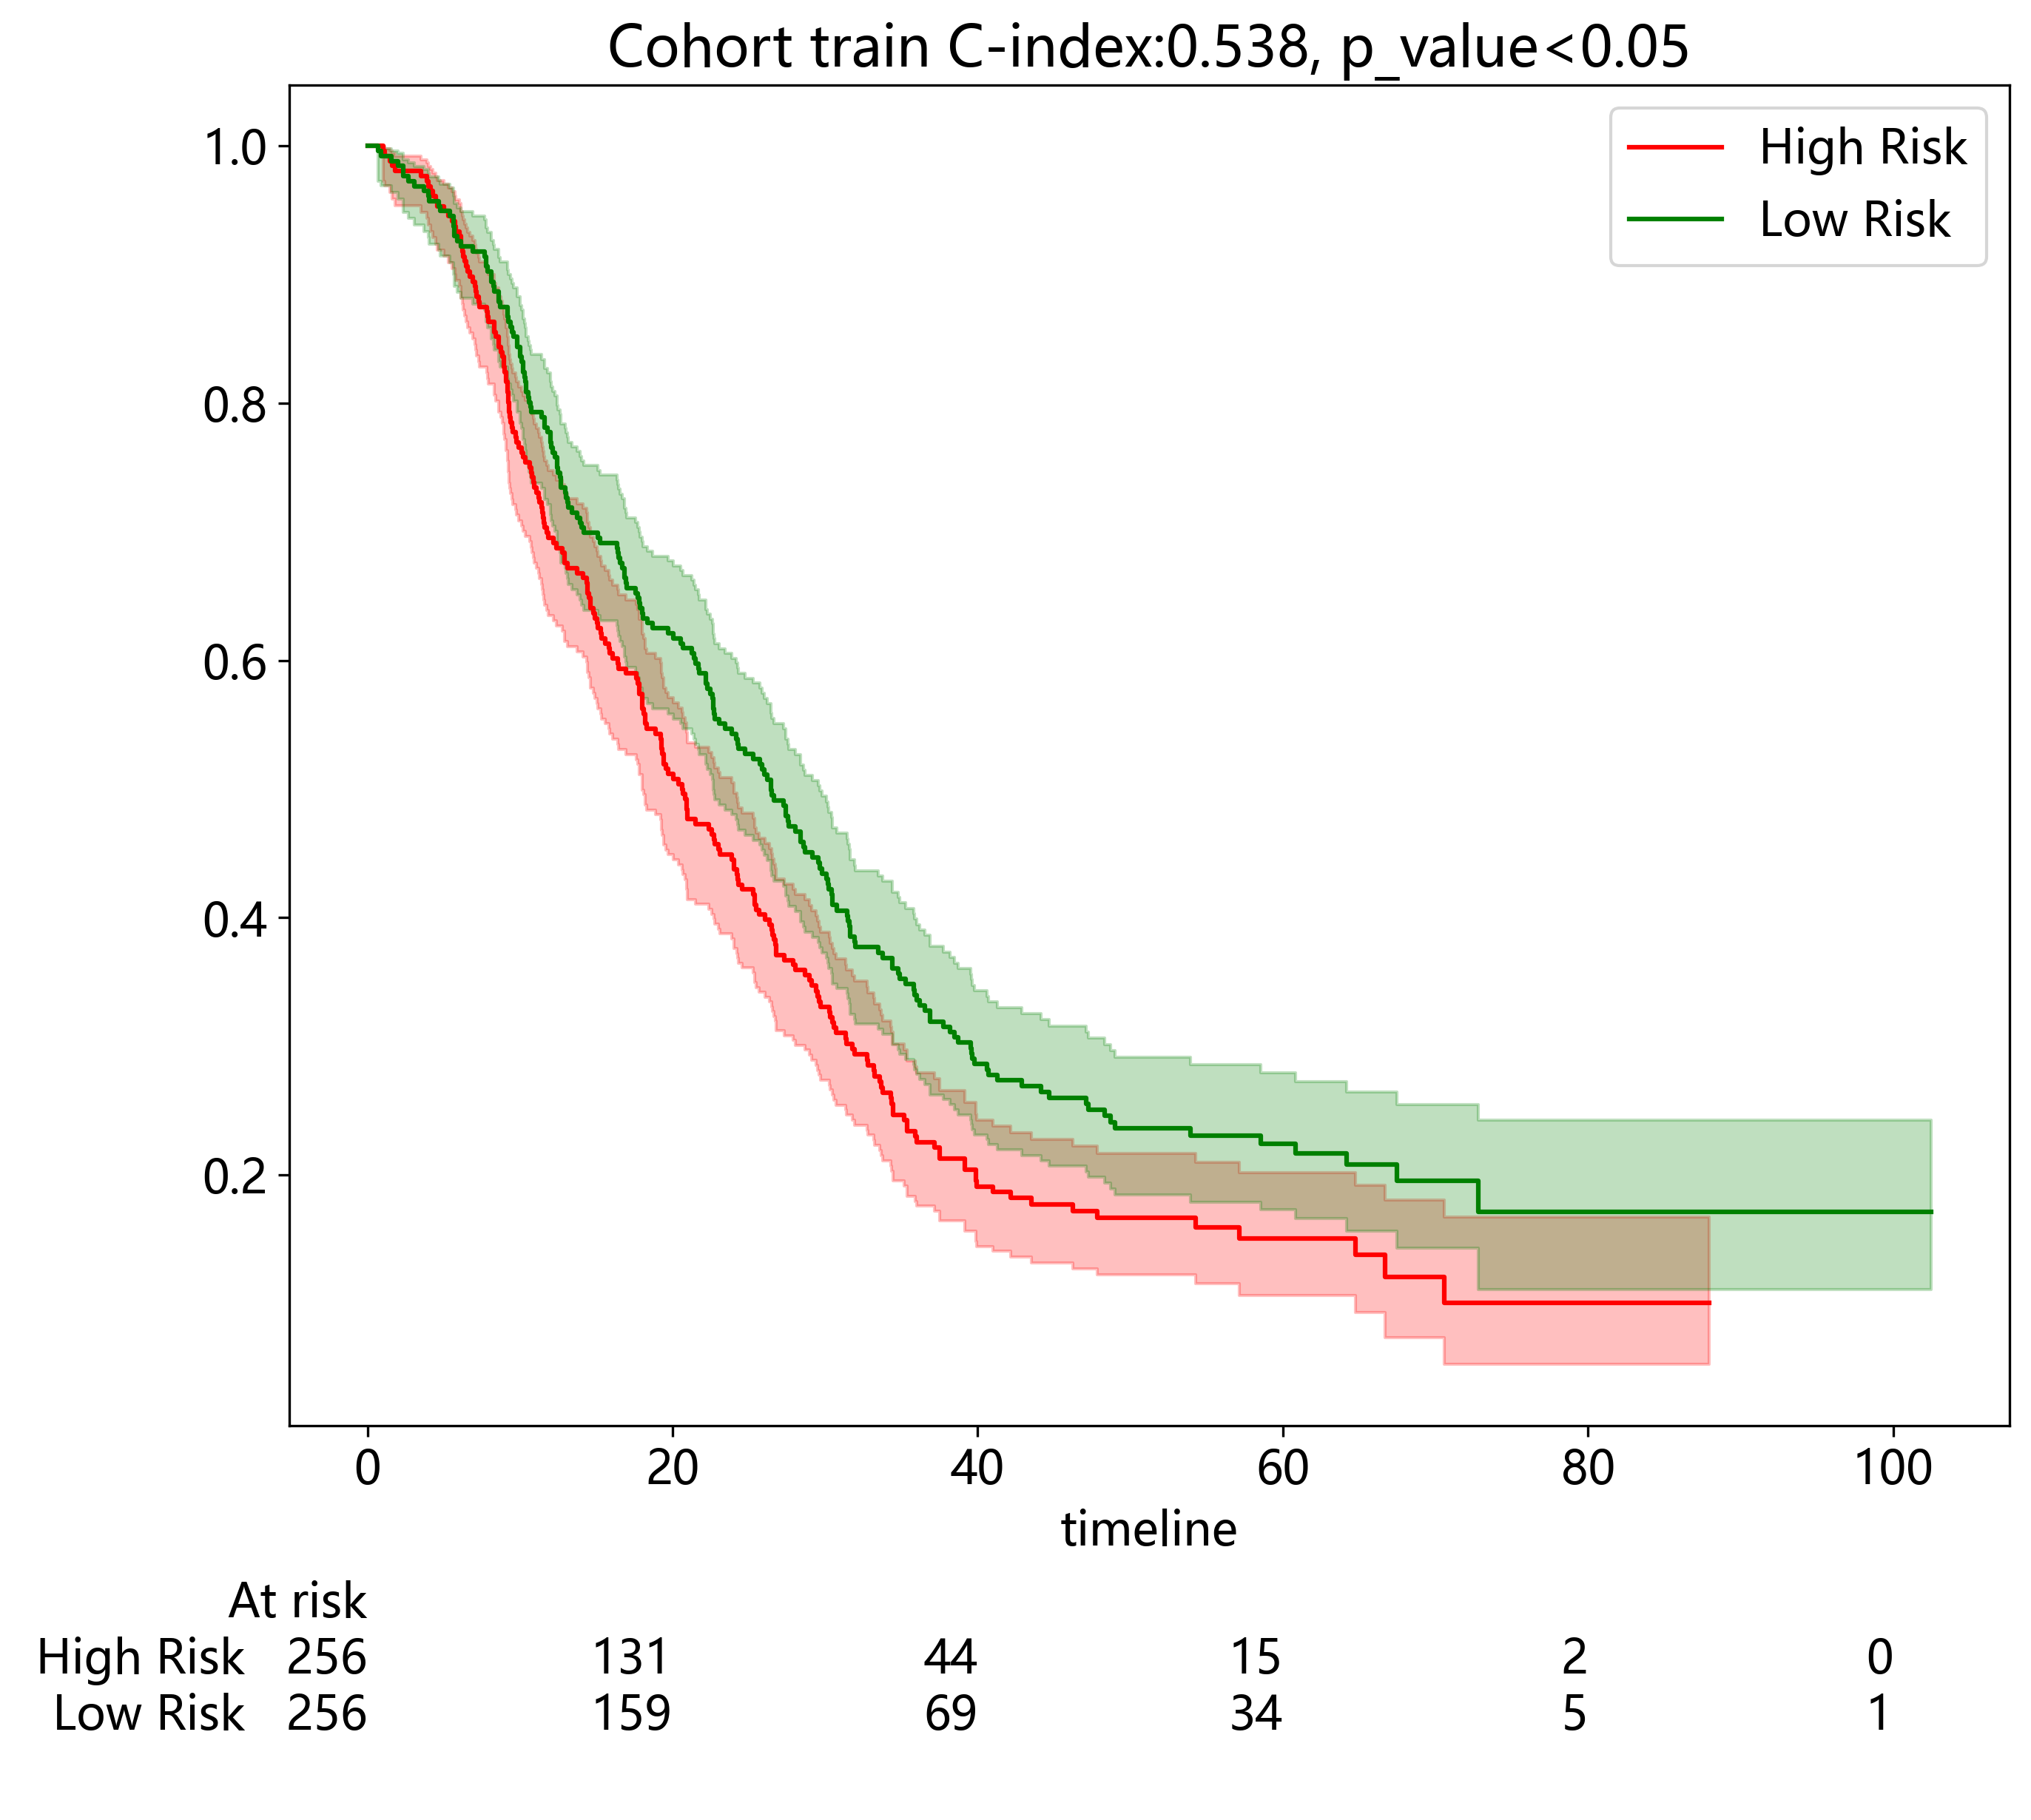

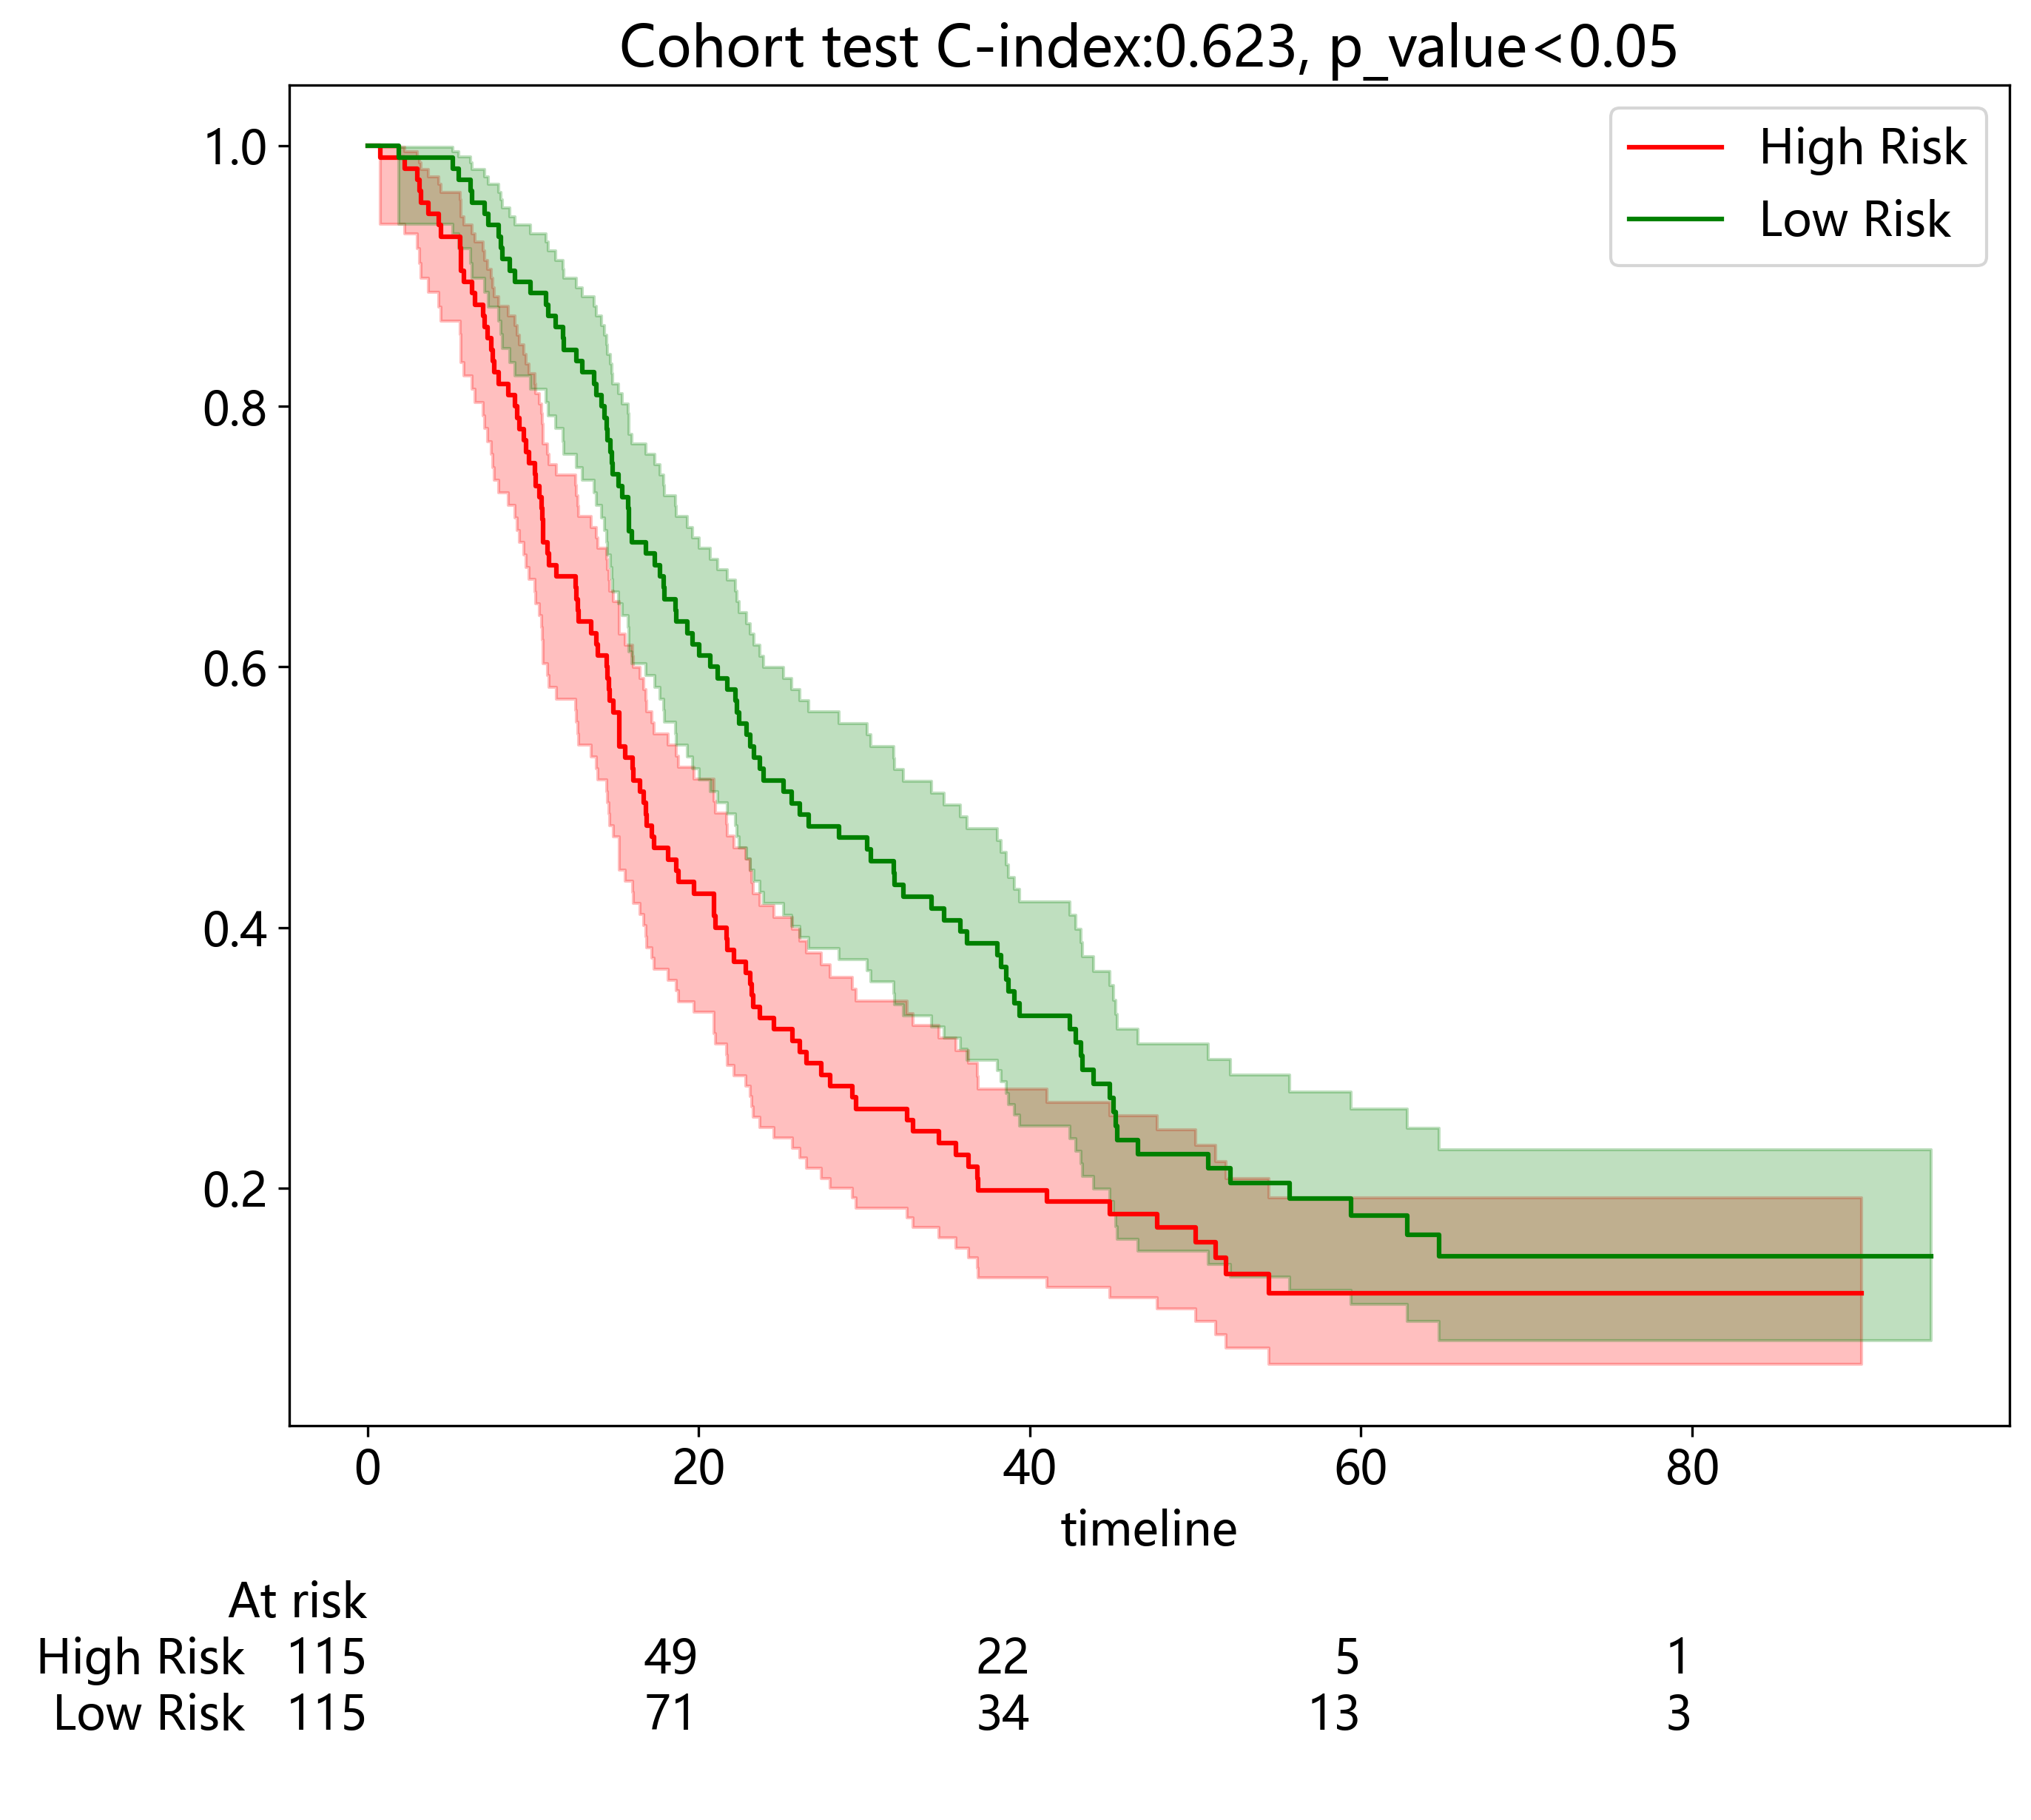

In [54]:
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt

for subset, test_data in val_datasets.items():
    if subset == 'test_ex':
        continue
    c_index = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     y_pred = cph.predict_median(test_data[[c for c in test_data.columns if c != 'ID']])
#     cox_data = pd.concat([test_data, y_pred], axis=1)
#     mean = cox_data.describe()[0.5]['mean']
#     cox_data['HR'] = cox_data[0.5] < mean
    y_pred = cph.predict_partial_hazard(test_data[[c for c in test_data.columns if c != 'ID']])
    cox_data = pd.concat([test_data, y_pred], axis=1)
    mean = cox_data.describe()[0]['50%']
    cox_data['HR'] = cox_data[0] > mean
#     cox_data['HR'] = cox_data[0] > 1

    dem = (cox_data["HR"] == True)
    results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                           event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
    p_value = f"={results.p_value:.4f}" if results.p_value > 0.05 else '<0.05'
    plt.title(f"Cohort {subset} C-index:{c_index:.3f}, p_value{p_value}")
    if sum(dem):
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
        kmf_high.plot_survival_function(color='r')
    if sum(~dem):
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
        kmf_low.plot_survival_function(color='g')
    add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
    plt.savefig(f'img/{task_type}KM_{subset}.svg', bbox_inches='tight')
    plt.show()

In [30]:
import os
import numpy as np

def get_prediction(model: CoxPHFitter, data, ID=None, **kwargs):
    hr = model.predict_partial_hazard(data)
    expectation = model.predict_expectation(data)
    
    predictions = pd.concat([hr, expectation], axis=1)
    predictions.columns = ['HR', 'expectation']
    if ID is not None:
        predictions = pd.concat([ID, hr, expectation], axis=1)
        predictions.columns = ['ID', 'HR', 'expectation']
    else:
        predictions = pd.concat([hr, expectation], axis=1)
        predictions.columns = ['HR', 'expectation']
    return predictions
os.makedirs('results', exist_ok=True)
for subset, test_data in val_datasets.items():
    resuslts = get_prediction(cph, test_data, ID=test_data['ID'])
    resuslts.to_csv(f'results/{task_type}cox_predictions_{subset}.csv', index=False)